In [1]:
import soundfile as sf
import numpy as np
import tensorflow as tf
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
import scipy

In [2]:
block_len = 512
block_shift = 128

In [3]:
# Set the path of pretrained model
model = tf.saved_model.load(r'PATH_PRETRAINED_MODEL')
infer = model.signatures["serving_default"]

In [4]:
# Set the noisy audio path
filename = "filename.wav"
filepath = os.path.join(r"DIRECTORY_OF_NOISY_AUDIO",filename)

In [5]:
# Load noisy audio file
audio,fs = librosa.load(filepath,sr=16000)

In [6]:
if fs != 16000:
    raise ValueError('This model only supports 16k sampling rate.')
out_file = np.zeros((len(audio)))
# create buffer
in_buffer = np.zeros((block_len))
out_buffer = np.zeros((block_len))
# calculate number of blocks
num_blocks = (audio.shape[0] - (block_len-block_shift)) // block_shift
for idx in range(num_blocks):
    # shift values and write to buffer
    in_buffer[:-block_shift] = in_buffer[block_shift:]
    in_buffer[-block_shift:] = audio[idx*block_shift:(idx*block_shift)+block_shift]
    # create a batch dimension of one
    in_block = np.expand_dims(in_buffer, axis=0).astype('float32')
    # process one block
    out_block= infer(tf.constant(in_block))['conv1d_1']
    # shift values and write to buffer
    out_buffer[:-block_shift] = out_buffer[block_shift:]
    out_buffer[-block_shift:] = np.zeros((block_shift))
    out_buffer  += np.squeeze(out_block)
    # write block to output file
    out_file[idx*block_shift:(idx*block_shift)+block_shift] = out_buffer[:block_shift]

In [7]:
# Save predicted output
outPath = os.path.join(r"DIRECTORY_OUTPUT_FILE","out_" + filename)
sf.write(outPath, out_file, fs) 

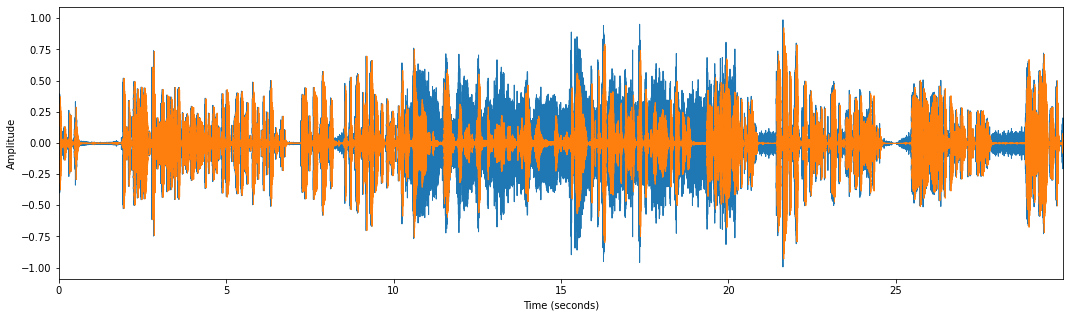

In [8]:
# Plot noisy and predicted output

plt.figure(figsize=(18,5))
librosa.display.waveplot(y=audio, sr = fs)
librosa.display.waveplot(y=out_file, sr = fs)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()